In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import polars as pl

df = pl.read_parquet("dataset_1y.parquet")

# Conjunt global de timestamps esperats
n_total_ts = df["timestamp"].n_unique()

coverage = (
    df.group_by("idTram")
      .agg(pl.col("timestamp").n_unique().alias("n_ts"))
      .with_columns([
          (pl.lit(n_total_ts) - pl.col("n_ts")).alias("missing_count"),
          (pl.col("n_ts") / n_total_ts * 100).alias("coverage_pct")
      ])
      .sort("coverage_pct")
)

print(coverage)


shape: (532, 4)
┌────────┬───────┬───────────────┬──────────────┐
│ idTram ┆ n_ts  ┆ missing_count ┆ coverage_pct │
│ ---    ┆ ---   ┆ ---           ┆ ---          │
│ i64    ┆ u32   ┆ u32           ┆ f64          │
╞════════╪═══════╪═══════════════╪══════════════╡
│ 18     ┆ 47942 ┆ 0             ┆ 100.0        │
│ 402    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 33     ┆ 47942 ┆ 0             ┆ 100.0        │
│ 298    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 277    ┆ 47942 ┆ 0             ┆ 100.0        │
│ …      ┆ …     ┆ …             ┆ …            │
│ 485    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 253    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 244    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 128    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 503    ┆ 47942 ┆ 0             ┆ 100.0        │
└────────┴───────┴───────────────┴──────────────┘


In [ ]:
import polars as pl

df = (
    pl.read_parquet("dataset_1y.parquet")
    .select(["idTram", "timestamp"])
    .sort(["idTram", "timestamp"])
    .with_columns(
        (pl.col("timestamp") - pl.col("timestamp").shift(1))
        .over("idTram")
        .alias("delta")
    )
)

# salts > 6 min
gaps = (
    df.filter(pl.col("delta") > pl.duration(minutes=6))
      .with_columns([
          pl.col("timestamp").alias("gap_end"),
          pl.col("timestamp").shift(1).over("idTram").alias("gap_start"),
          pl.col("delta").dt.total_minutes().alias("gap_minutes")
      ])
      .drop_nulls(subset=["gap_start"])
)

print(gaps.sort("gap_minutes", descending=True))


shape: (19_893_608, 6)
┌────────┬──────────────┬──────────────┬──────────────────────┬──────────────────────┬─────────────┐
│ idTram ┆ timestamp    ┆ delta        ┆ gap_end              ┆ gap_start            ┆ gap_minutes │
│ ---    ┆ ---          ┆ ---          ┆ ---                  ┆ ---                  ┆ ---         │
│ i64    ┆ datetime[μs] ┆ duration[μs] ┆ datetime[μs]         ┆ datetime[μs]         ┆ i64         │
╞════════╪══════════════╪══════════════╪══════════════════════╪══════════════════════╪═════════════╡
│ 1      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023-12-05 10:05:53  ┆ 8570        │
│        ┆ 09:05:54     ┆              ┆                      ┆                      ┆             │
│ 2      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023-12-05 10:05:53  ┆ 8570        │
│        ┆ 09:05:54     ┆              ┆                      ┆                      ┆             │
│ 3      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023

In [12]:
import polars as pl

df = pl.read_parquet("dataset_1y.parquet")

# 1) Treu els timestamps únics i ordena
ts = (
    df.select("timestamp")
      .unique()
      .sort("timestamp")
      .with_columns(
          (pl.col("timestamp") - pl.col("timestamp").shift(1)).alias("delta")
      )
)

# 2) Filtra salts > 6 minuts (5 min esperats + marge)
gaps_global = (
    ts.filter(pl.col("delta") > pl.duration(minutes=6))
      .with_columns([
          pl.col("timestamp").alias("gap_end"),
          pl.col("timestamp").shift(1).alias("gap_start"),
          pl.col("delta").dt.total_minutes().alias("gap_minutes")
      ])
      .drop_nulls(subset=["gap_start"])
      .select(["gap_start", "gap_end", "gap_minutes"])
)

print(gaps_global.sort("gap_minutes", descending=True).head(40))
gaps_global.write_csv("global_temporal_gaps.csv")


shape: (40, 3)
┌─────────────────────┬─────────────────────┬─────────────┐
│ gap_start           ┆ gap_end             ┆ gap_minutes │
│ ---                 ┆ ---                 ┆ ---         │
│ datetime[μs]        ┆ datetime[μs]        ┆ i64         │
╞═════════════════════╪═════════════════════╪═════════════╡
│ 2023-12-05 10:05:53 ┆ 2023-12-11 09:05:54 ┆ 8570        │
│ 2024-04-03 15:10:55 ┆ 2024-04-08 14:10:52 ┆ 7134        │
│ 2024-01-19 18:55:56 ┆ 2024-01-22 10:30:45 ┆ 3814        │
│ 2024-08-09 17:05:54 ┆ 2024-08-12 08:10:52 ┆ 3784        │
│ 2023-12-04 01:40:57 ┆ 2023-12-05 08:15:57 ┆ 1835        │
│ …                   ┆ …                   ┆ …           │
│ 2024-01-02 03:00:52 ┆ 2024-01-02 04:35:51 ┆ 94          │
│ 2024-03-09 05:25:52 ┆ 2024-03-09 06:55:52 ┆ 90          │
│ 2024-05-26 03:30:54 ┆ 2024-05-26 04:55:53 ┆ 84          │
│ 2024-05-31 18:10:53 ┆ 2024-05-31 19:30:53 ┆ 80          │
│ 2024-03-09 03:00:54 ┆ 2024-03-09 04:20:53 ┆ 79          │
└─────────────────────┴──

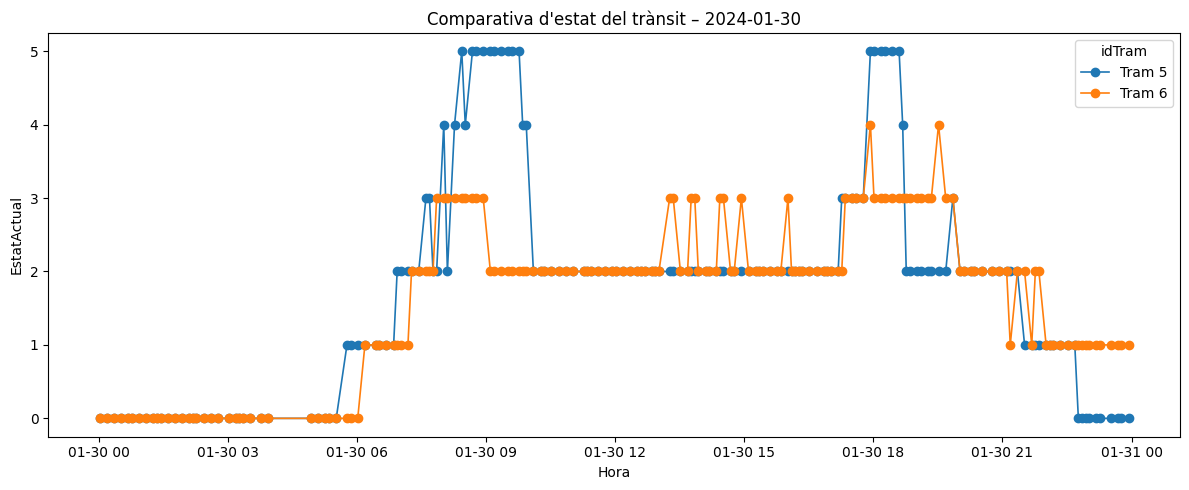

In [22]:
# ── Configura IDs i dia ─────────────────────────────
ids  = [5, 6]        # trams a comparar
dia  = "2024-01-30"    # dia d'interès (YYYY-MM-DD)

# ── Llegeix i filtra ───────────────────────────────
df = (
    pl.read_parquet("dataset_1y.parquet")
      .filter(pl.col("idTram").is_in(ids))
      .filter(pl.col("timestamp").cast(pl.Date) == pd.to_datetime(dia).date())
)

pdf = df.to_pandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])

# ── Gràfic sobreposat ──────────────────────────────
plt.figure(figsize=(12,5))
for tid in ids:
    subset = pdf[pdf["idTram"] == tid]
    plt.plot(subset["timestamp"], subset["estatActual"],
             marker="o", lw=1.2, label=f"Tram {tid}")

plt.title(f"Comparativa d'estat del trànsit – {dia}")
plt.xlabel("Hora")
plt.ylabel("EstatActual")
plt.legend(title="idTram")
plt.tight_layout()
plt.show()

/var/folders/83/gt48b8vj7tbdkb4w2zf5n42m0000gn/T/ipykernel_61108/3998475946.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = pdf["estatActual"].resample("1H").mean()


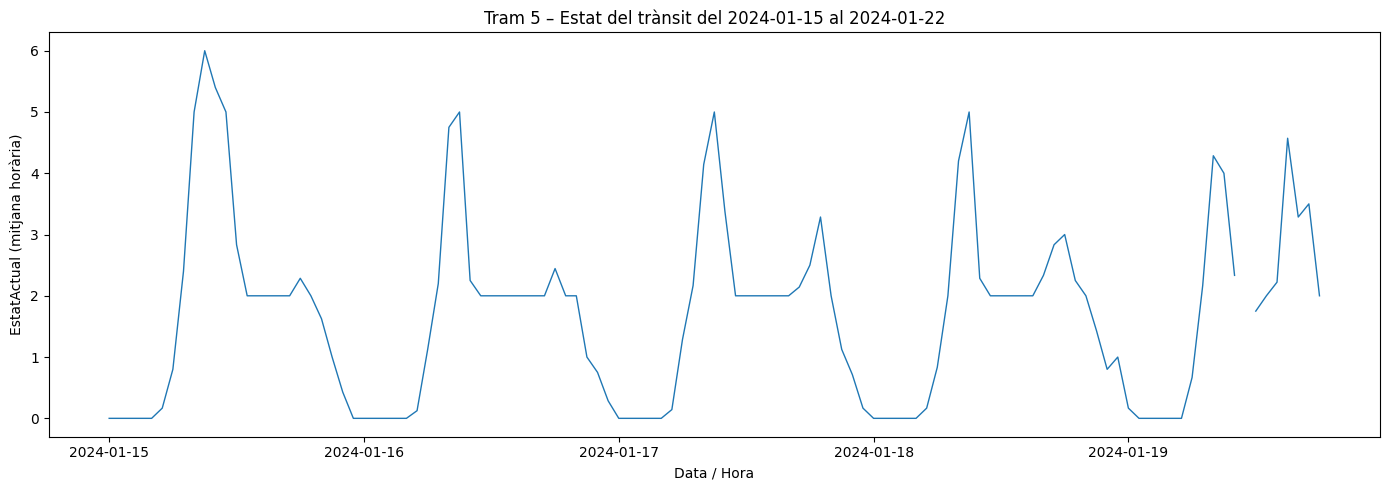

ValueError: This function does not handle missing values

In [24]:
from datetime import datetime

tram_id = 5
start   = datetime(2024, 1, 15)
end     = datetime(2024, 1, 22)

# --- Llegeix i filtra correctament ---
df = (
    pl.read_parquet("dataset_1y.parquet")
      .filter(pl.col("idTram") == tram_id)
      .filter((pl.col("timestamp") >= pl.lit(start)) &
              (pl.col("timestamp") <  pl.lit(end)))
)

pdf = df.to_pandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
pdf = pdf.set_index("timestamp")

# --- Resample a 1 hora ---
hourly = pdf["estatActual"].resample("1H").mean()

# --- Gràfic d'una setmana ---
plt.figure(figsize=(14,5))
plt.plot(hourly.index, hourly.values, lw=1)
plt.title(f"Tram {tram_id} – Estat del trànsit del {start.date()} al {end.date()}")
plt.xlabel("Data / Hora")
plt.ylabel("EstatActual (mitjana horària)")
plt.tight_layout()
plt.show()

# --- Descomposició (patró diari) ---
result = seasonal_decompose(hourly, period=24)   # 24 hores = cicle diari
result.plot()
plt.suptitle(f"Descomposició seasonal – Tram {tram_id}", y=1.02)
plt.show()


In [31]:
df = (
    pl.read_parquet("/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/data/dataset_1y.parquet")
)

df.sort(by=["timestamp", "idTram"])
df.unique(maintain_order=True)

idTram,data,estatActual,estatPrevist,timestamp
i64,str,i64,i64,datetime[μs]
1,"""20231201000058""",1,0,2023-12-01 00:00:58
1,"""20231201001555""",1,1,2023-12-01 00:15:55
1,"""20231201002056""",0,0,2023-12-01 00:20:56
1,"""20231201003057""",1,1,2023-12-01 00:30:57
1,"""20231201004054""",0,0,2023-12-01 00:40:54
…,…,…,…,…
539,"""20241130230053""",0,0,2024-11-30 23:00:53
539,"""20241130231054""",0,0,2024-11-30 23:10:54
539,"""20241130232054""",0,0,2024-11-30 23:20:54


In [2]:
import sys
from pathlib import Path

# Afegeix la carpeta arrel del projecte, la que CONTÉ la carpeta 'src'
project_root = Path("/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg")
sys.path.append(str(project_root))

from src.data_prep.gaps import find_gaps, classify_gaps, find_global_gaps

df = pl.read_parquet("/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/data/dataset_1y.parquet")
gaps = find_gaps(df)
gaps = classify_gaps(gaps)
gaps_global = find_global_gaps(df)

In [6]:
gaps

idTram,gap_start,gap_end,gap_minutes,gap_type
i64,datetime[μs],datetime[μs],i64,str
1,2023-12-01 00:15:55,2023-12-01 00:30:57,10,"""short"""
1,2023-12-01 00:30:57,2023-12-01 00:40:54,9,"""short"""
1,2023-12-01 00:40:54,2023-12-01 00:50:53,9,"""short"""
1,2023-12-01 00:50:53,2023-12-01 01:10:54,9,"""short"""
1,2023-12-01 01:10:54,2023-12-01 01:25:55,15,"""short"""
…,…,…,…,…
539,2024-11-30 22:45:52,2024-11-30 23:00:53,15,"""short"""
539,2024-11-30 23:00:53,2024-11-30 23:10:54,10,"""short"""
539,2024-11-30 23:10:54,2024-11-30 23:20:54,10,"""short"""


In [7]:
gaps_global

gap_start,gap_end,gap_minutes
datetime[μs],datetime[μs],i64
2023-12-01 00:15:55,2023-12-01 00:30:57,10
2023-12-01 00:30:57,2023-12-01 00:40:54,9
2023-12-01 00:40:54,2023-12-01 00:50:53,9
2023-12-01 00:50:53,2023-12-01 01:10:54,9
2023-12-01 01:10:54,2023-12-01 01:25:55,15
…,…,…
2024-11-30 22:45:52,2024-11-30 23:00:53,15
2024-11-30 23:00:53,2024-11-30 23:10:54,10
2024-11-30 23:10:54,2024-11-30 23:20:54,10


In [ ]:
from datetime import timedelta

import polars as pl



statistic,idTram,timestamp,estatActual,is_gap,gap_type,estatActual_imputed
str,f64,str,f64,f64,str,f64
"""count""",5.6075992e7,"""56075992""",0.0,5.6075992e7,"""0""",5.6075992e7
"""null_count""",0.0,"""0""",5.6075992e7,0.0,"""56075992""",0.0
"""mean""",267.18985,"""2024-05-31 23:52:30""",null,1.0,null,0.0
"""std""",154.612869,null,null,null,null,null
"""min""",1.0,"""2023-12-01 00:00:00""",null,1.0,null,0.0
"""25%""",134.0,"""2024-03-01 11:55:00""",null,null,null,null
"""50%""",267.0,"""2024-05-31 23:55:00""",null,null,null,null
"""75%""",399.0,"""2024-08-31 11:50:00""",null,null,null,null
"""max""",539.0,"""2024-11-30 23:45:00""",null,1.0,null,0.0
